# Spatial data mining with machine learning to reveal mineral exploration targets under cover in the Gawler Craton, South Australia
*Nathaniel Butterworth and Nicholas Barnett-Moore*


Last updated 25th September 2023

This notebook covers the full workflow and produces the final figures and grids. It should be as simple as running each cell.
Read the comments throughout the code along with the paper for a full understanding. 

Contact: nathaniel.butterworth@sydney.edu.au

In [1]:
#Import libraries for data manipulations
import pandas as pd
import numpy as np
import random
import scipy
from scipy import io

#Import libraries for plotting
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import cartopy.crs as ccrs
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
from mpl_toolkits import mplot3d
import matplotlib.mlab as ml
from cartopy.io.img_tiles import Stamen
from numpy import linspace, meshgrid
from matplotlib.path import Path
from matplotlib.patches import PathPatch

#Import libraries for tif, shapefile, and geodata manipulations
import shapefile
from shapely.geometry import Point
from shapely.geometry import shape

#Import Machine Learning libraries
#from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn import preprocessing
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder


#Import libraries for multi-threading capabilities
#from dask import delayed,compute
#from dask.distributed import Client, progress
import time
import math

In [2]:
#Define simple helper functions used in workflow

def coregPoint(point,data,region):
    '''
    Finds the nearest neighbour to a point from a bunch of other points
    point - array([longitude,latitude])
    data - array
    region - integer, same units as data
    '''
    tree = scipy.spatial.cKDTree(data)
    dists, indexes = tree.query(point,k=1,distance_upper_bound=region) 

    if indexes==len(data):
        print("Warning: no data found",point,"your workflow will likely break later!")
        return (0,0)
    else:
        return (indexes,dists)
    
#
def points_in_circle(circle, arr):
    '''
    A generator to return all points whose indices are within given circle.
    http://stackoverflow.com/a/2774284
    Warning: If a point is near the the edges of the raster it will not loop 
    around to the other side of the raster!
    '''
    i0,j0,r = circle

    for i in range(intceil(i0-r),intceil(i0+r)):
        ri = np.sqrt(r**2-(i-i0)**2)
        for j in range(intceil(j0-ri),intceil(j0+ri)):
            if (i >= 0 and i < len(arr[:,0])) and (j>=0 and j < len(arr[0,:])):
                yield arr[i][j]

#            
def intceil(x):
    return int(np.ceil(x))                                            

#
def coregRaster(point,data,region):
    '''
    Finds the mean value of a raster, around a point with a specified radius.
    point - array([longitude,latitude])
    data - array
    region - integer, same units as data
    '''
    i0=point[1]
    j0=point[0]
    r=region #In units of degrees
    pts_iterator = points_in_circle((i0,j0,region), data)
    pts = np.array(list(pts_iterator))
    #remove values outside the region which for there is no data (0.0).
    #print(pts)
    pts = pts[pts != 0.]
    if np.isnan(np.nanmean(pts)):
        #print(point,"nan")
        #pts=np.median(data)
        pts=-9999.
        #print("returning",pts)

    return(np.nanmean(pts))

#Make a function that can turn point arrays into a full meshgrid
# def grid(x, y, z, resX=100, resY=100):
#     "Convert 3 column data to matplotlib grid"
#     xi = linspace(min(x), max(x), resX)
#     yi = linspace(min(y), max(y), resY)
#     Z = scipy.interpolate.griddata(x, y, z, xi, yi,method='linear')
#     X, Y = meshgrid(xi, yi)
#     return X, Y, Z

#Define a function to read the netcdf files
def readnc(filename):
    tic=time.time()
    rasterfile=filename
    data = scipy.io.netcdf_file(rasterfile,'r')
    xdata=data.variables['lon'][:]
    ydata=data.variables['lat'][:]
    zdata=np.array(data.variables['Band1'][:])

    toc=time.time()
    print(rasterfile, "in", toc-tic)
    print("spacing x", xdata[2]-xdata[1], "y", ydata[2]-ydata[1], np.shape(zdata),np.min(xdata),np.max(xdata),np.min(ydata),np.max(ydata))

    return(xdata,ydata,zdata)

#Define a function to find what polygon a point lives inside (speed imporivements can be made here)
# def shapeExplore(point,shapes,recs,record):
#     #'record' is the column index you want returned
#     for i in range(len(shapes)):
#         boundary = shapes[i]
#         if Point((point.lon,point.lat)).within(shape(boundary)):
#             return(recs[i][record])
#     #if you have been through the loop with no result
#     return(-9999.)

def shapeExplore(point,shape_objects,recs,record_of_interest_index):
    '''
        shape_objects: a list of shapely shape objects, e.g 
           shape_objects = [shape(shp) for shp in shapesGeol]
        point: a shapely Point, e.g. Point(131,-51)
        recs: List of shapefile records e.g
            recs = shapefile.Reader("example.shp").records()
        record_of_interest_index: which record index to return.
    '''
    for i, polygon in enumerate(shape_objects):
        if point.within(polygon):
            return(recs[i][record_of_interest_index])
    #if you have been through the loop with no result
    return('-9999')

# Part 1 
### Wrangling the raw data

### Deposit locations - mine and mineral occurances
The most importantt dataset for this workflow is the currently known locations of mineral occurences. Using the data we already know about these known-deposits we will build a model to predict where future occurences will be.

In [3]:
#Set the filename
mineshape="SA-DATA/MinesMinerals/mines_and_mineral_occurrences_all.shp"

#Set shapefile attributes and assign
sf = shapefile.Reader(mineshape)
fields = [x[0] for x in sf.fields][1:]
records = sf.records()
shps = [s.points for s in sf.shapes()]

#write into a dataframe fo easy use
df = pd.DataFrame(columns=fields, data=records)

In [4]:
#See what the dataframe looks like
df

,MINDEP_NO,DEP_NAME,REFERENCE,COMM_CODE,COMMODS,COMMOD_MAJ,COMM_SPECS,GCHEM_ASSC,DISC_YEAR,CLASS_CODE,...,NORTHING,ZONE,LONGITUDE,LATITUDE,SVY_METHOD,HORZ_ACC,SRCE_MAP,SRCE_CNTRE,COMMENTS,O_MAP_SYMB
0,5219,MOUNT DAVIES NO.2A,RB 65/80,Ni,Nickel,Ni,ELMT,,1893.0,OCCURRENCE,...,7112524.68,52,129.200549,-26.106335,Digitised,2000.0,500k meis,,,T\fe1
1,52,ONE STONE,MRR 138,Ni,Nickel,Ni,ELMT,Ni-Cr,1975.0,OCCURRENCE,...,7110551.56,53,132.775358,-26.107124,"Sourced from documents (PLANS, ENV, RB,etc)",500.0,71-385,,,T\si
2,8314,HINCKLEY RANGE,,Fe,Iron,Fe,ELMT,,1961.0,OCCURRENCE,...,7111381.52,52,129.101731,-26.116761,"Sourced from documents (PLANS, ENV, RB,etc)",500.0,,,,Mg
3,69,KALKA,RB 91/103,"V, ILM","Vanadium, Ilmenite",V,ELMT,Fe-V-Ti,1968.0,OCCURRENCE,...,7110521.49,52,129.116042,-26.124516,(DISUSED) Map Plot,100.0,1 MILE,mgt polygon on digital map,,Mg2
4,65,ECHIDNA,RB 91/103,Ni,Nickel,Ni,ELMT,Ni,1991.0,OCCURRENCE,...,7108531.53,53,132.770515,-26.125281,(DISUSED) Map Plot,20.0,50K GEOL,DH ECHIDNA PROSPECT,,LMb
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8672,6937,YARINGA,RB 43/94,QTZE,Quartzite,QTZE,ROCK,,1956.0,OCCURRENCE,...,6066051.52,54,138.254441,-35.517924,Google Earth image,200.0,50k moc,fenced yard,,Eec
8673,4729,WELCHS,MSC #19,SCHT,Schist,SCHT,ROCK,,1930.0,OCCURRENCE,...,6066681.48,54,138.648619,-35.520578,Digital Image,20.0,50k topo,,,Elb
8674,4718,ARCADIAN,MSC #2,CLAY,Clay,CLAY,ROCK,,1921.0,DEPOSIT,...,6066561.56,54,138.660599,-35.521892,Digital Image,5.0,Plan 1951-0327,Pit,,Q
8675,1436,MCDONALD,MSC #7,Au,Gold,Au,ELMT,Au,1901.0,OCCURRENCE,...,6065991.54,54,138.436645,-35.522477,Google Earth image,200.0,50k moc,qz float,,qz


### Set the commodity we want to target

In [5]:
commname='Ni'

In [6]:
#Pull our all the occurences of the commodity and go from there
comm=df[df['COMM_CODE'].str.contains(commname)].copy()
comm=comm.reset_index(drop=True)
print("Shape of "+ commname, comm.shape)

#Can make simple subsets of the data here as needed
#commsig=comm[comm.SIZE_VAL!="Low Significance"]
#comm=comm[comm.SIZE_VAL!="Low Significance"]
#comm=comm[comm.COX_CLASS == "Olympic Dam Cu-U-Au"]
#comm=comm[(comm.lon<max(xval)) & (comm.lon>min(xval)) & (comm.lat>min(yval)) & (comm.lat<max(yval))]

#Can save subset to a file
#comm.to_csv("copper-deposits.csv")

Shape of Ni (65, 43)


## Wrangle the geophysical and geological datasets
Each geophysical dataset could offer instight into various commodities. Here we load in the pre-processed datasets and prepare them for further manipulations, data-mining, and machine learning.

### Resistivity xyz data

In [7]:
#Read in the data
data_res=pd.read_csv("SA-DATA/Resistivity/AusLAMP_MT_Gawler.xyzr",
                     sep='\s+',header=0,names=['lat','lon','depth','resistivity'])
data_res.head()

,lat,lon,depth,resistivity
0,-27.363931,128.680796,-25.0,2.0007
1,-27.659362,128.662322,-25.0,1.9979
2,-27.886602,128.647965,-25.0,1.9948
3,-28.061394,128.636833,-25.0,1.9918
4,-28.195844,128.628217,-25.0,1.9885


In [8]:
#Simplify the dataframe with some vectors
lon_res=data_res.lon.values
lat_res=data_res.lat.values
depth_res=data_res.depth.values
res_res=data_res.resistivity.values

In [9]:
#Split the data into unique depth layers
f=[]
for i in data_res.depth.unique():
    f.append(data_res[data_res.depth==i].values)

f=np.array(f)
print("Resitivity in:", np.shape(f))

#Print unique depth layers
#[print(i) for i in data_res.depth.unique()]

Resitivity in: (63, 11008, 4)


In [10]:
#Set an array we can interrogate values of later
#This is the same for all resistivity vectors
lonlatres=np.c_[f[0,:,1],f[0,:,0]]
lonres=f[0,:,1]
latres=f[0,:,0]

### Faults and dykes vector polylines

In [11]:
#Get fault data neo
faultshape="SA-DATA/Neoproterozoic - Ordovician faults_shp/Neoproterozoic - Ordovician faults.shp"
shapeRead = shapefile.Reader(faultshape)
shapes  = shapeRead.shapes()
Nshp    = len(shapes)

faultsNeo=[]
for i in range(0,Nshp):
    for j in shapes[i].points:
        faultsNeo.append([j[0],j[1]])
faultsNeo=np.array(faultsNeo)

In [12]:
#Get fault data archean
faultshape="SA-DATA/Archaean - Early Mesoproterozoic faults_shp/Archaean - Early Mesoproterozoic faults.shp"
shapeRead = shapefile.Reader(faultshape)
shapes  = shapeRead.shapes()
Nshp    = len(shapes)

faultsArch=[]
for i in range(0,Nshp):
    for j in shapes[i].points:
        faultsArch.append([j[0],j[1]])
faultsArch=np.array(faultsArch)

In [13]:
#Get fault data dolerite dykes swarms
faultshape="SA-DATA/Gairdner Dolerite_shp/Gairdner Dolerite.shp"
shapeRead = shapefile.Reader(faultshape)
shapes  = shapeRead.shapes()
Nshp    = len(shapes)

faultsGair=[]
for i in range(0,Nshp):
    for j in shapes[i].points:
        faultsGair.append([j[0],j[1]])
faultsGair=np.array(faultsGair)

### Netcdf formatted raster grids

In [14]:
#TODO: Should be cleaned up and put into dictionary or similar.
#For now, reading individual datasets is fine
x1,y1,z1 = readnc("SA-DATA/aster-AlOH-cont.nc")
x2,y2,z2 = readnc("SA-DATA/aster-AlOH-comp.nc")
x3,y3,z3 = readnc("SA-DATA/aster-FeOH-cont.nc")
x4,y4,z4 = readnc("SA-DATA/aster-Ferric-cont.nc")
x5,y5,z5 = readnc("SA-DATA/aster-Ferrous-cont.nc")
x6,y6,z6 = readnc("SA-DATA/aster-Ferrous-index.nc")
x7,y7,z7 = readnc("SA-DATA/aster-MgOH-comp.nc")
x8,y8,z8 = readnc("SA-DATA/aster-MgOH-cont.nc")
x9,y9,z9 = readnc("SA-DATA/aster-green.nc")
x10,y10,z10 = readnc("SA-DATA/aster-kaolin.nc")
x11,y11,z11 = readnc("SA-DATA/aster-opaque.nc")
x12,y12,z12 = readnc("SA-DATA/aster-quartz.nc")
x13,y13,z13 = readnc("SA-DATA/aster-regolith-b3.nc")
x14,y14,z14 = readnc("SA-DATA/aster-regolith-b4.nc")
x15,y15,z15 = readnc("SA-DATA/aster-silica.nc")
x16,y16,z16 = readnc("SA-DATA/sa-base-elev.nc")
x17,y17,z17 = readnc("SA-DATA/sa-dem.nc")
x18,y18,z18 = readnc("SA-DATA/sa-base-dtb.nc")
x19,y19,z19 = readnc("SA-DATA/sa-mag-2vd.nc")
x20,y20,z20 = readnc("SA-DATA/sa-mag-rtp.nc")
x21,y21,z21 = readnc("SA-DATA/sa-mag-tmi.nc")
x22,y22,z22 = readnc("SA-DATA/sa-rad-dose.nc")
x23,y23,z23 = readnc("SA-DATA/sa-rad-k.nc")
x24,y24,z24 = readnc("SA-DATA/sa-rad-th.nc")
x25,y25,z25 = readnc("SA-DATA/sa-rad-u.nc")
x26,y26,z26 = readnc("SA-DATA/sa-grav.nc")

SA-DATA/aster-AlOH-cont.nc in 0.014458894729614258
spacing x 0.010000000000019327 y 0.00999999999999801 (1238, 1200) 129.004775 140.994775 -38.374825 -26.004825000000004
SA-DATA/aster-AlOH-comp.nc in 0.011046886444091797
spacing x 0.010000000000019327 y 0.00999999999999801 (1238, 1200) 129.004775 140.994775 -38.374825 -26.004825000000004
SA-DATA/aster-FeOH-cont.nc in 0.007439136505126953
spacing x 0.010000000000019327 y 0.00999999999999801 (1238, 1200) 129.004775 140.994775 -38.374825 -26.004825000000004
SA-DATA/aster-Ferric-cont.nc in 0.007421016693115234
spacing x 0.010000000000019327 y 0.00999999999999801 (1238, 1200) 129.004775 140.994775 -38.374825 -26.004825000000004
SA-DATA/aster-Ferrous-cont.nc in 0.007012128829956055
spacing x 0.010000000000019327 y 0.00999999999999801 (1238, 1200) 129.004775 140.994775 -38.374825 -26.004825000000004
SA-DATA/aster-Ferrous-index.nc in 0.007284879684448242
spacing x 0.010000000000019327 y 0.00999999999999801 (1238, 1200) 129.004775 140.994775 -3

/Users/nbutter/miniconda3/envs/geopy/lib/python3.9/site-packages/scipy/io/_netcdf.py:305: RuntimeWarning: Cannot close a netcdf_file opened with mmap=True, when netcdf_variables or arrays referring to its data still exist. All data arrays obtained from such files refer directly to data on disk, and must be copied before the file can be cleanly closed. (See netcdf_file docstring for more information on mmap.)
  warnings.warn((


### Categorical Geology in vector polygons

In [15]:
#Surface Geology, have converted unique map units to intger
geolshape=shapefile.Reader("SA-DATA/7MGeology/geology_simp.shp")

recsGeol    = geolshape.records()
shapesGeol  = geolshape.shapes()

#Archean basement geology
geolshape=shapefile.Reader("SA-DATA/Archaean_Early_Mesoprterzoic_polygons_shp/Archaean - Early Mesoproterozoic polygons.shp")

recsArch   = geolshape.records()
shapesArch  = geolshape.shapes()

# Part 2 - Spatial data mining of datasets

### Select the commodity and geophysical features to use 
Edit *commname* above and turn these labels on/off as required. 
Generally run data mining with all labels. 
Then can turn these features on/off before running ML if needed.

In [16]:
lons=['lon','lat']
reslabels = [     
'res-25',
'res-77',
'res-136',
'res-201',
'res-273',
'res-353',
'res-442',
'res-541',
'res-650',  
'res-772',
'res-907',
'res-1056',
'res-1223',
'res-1407',
'res-1612',
'res-1839',
'res-2092',
'res-2372',
'res-2683',
'res-3028',
'res-3411',
'res-3837',    
'res-4309',
'res-4833',
'res-5414',
'res-6060',
'res-6776',
'res-7572',
'res-8455',
'res-9435',
'res-10523',
'res-11730',
'res-13071',
'res-14559',
'res-16210',
'res-18043',   
'res-20078',
'res-22337',
'res-24844',
'res-27627',
'res-30716',
'res-34145',
'res-37951',
'res-42175',
'res-46865',
'res-52070',
'res-57847',
'res-64261',
'res-71379',
'res-79281',
'res-88052',
'res-97788',
'res-108595',
'res-120590',
'res-133905',
'res-148685',
'res-165090',
'res-183300',
'res-203513',
'res-225950',
'res-250854',
'res-278498',
'res-309183'
]
  
faultlabels=[
    "neoFaults",
    "archFaults",
    "gairFaults"
]

numerical_features=reslabels+faultlabels+[
"aster1-AlOH-cont",
"aster2-AlOH",
"aster3-FeOH-cont",
"aster4-Ferric-cont",
"aster5-Ferrous-cont",
"aster6-Ferrous-index",
"aster7-MgOH-comp",
"aster8-MgOH-cont",
"aster9-green",
"aster10-kaolin",
"aster11-opaque",
"aster12-quartz",
"aster13-regolith-b3",
"aster14-regolith-b4",
"aster15-silica",
"base16",
"dem17",
"dtb18",
"mag19-2vd",
"mag20-rtp",
"mag21-tmi",
"rad22-dose",
"rad23-k",
"rad24-th",
"rad25-u",
"grav26"
]

categorical_features=[
'archean27',
'geol28',
'random'
]

In [17]:
print("Number of geophysical layers: ", len(numerical_features))

Number of geophysical layers:  92


### Generate the non-deposit dataset

This step is important. There are numerous ways to generate our non-deposit set, each with different benefits and trade-offs.
The randomisation of points throughout *some* domain appears to be robust. But you must think, is this domain a reasonable estimation of "background" geophysics/geology? Why are you picking these locations as non-deposits? Will they be over/under-representing actual deposits? Will they be over/under-representing actual non-deposits?

Change the lows, highs, and sizes as desired. And enforce the points are with some confinement area if needed.
A good place to start is within the spatial extent of the known deposits/commodity.

In [18]:
#Generate "non-deposit" points within the same spatial domains as deposits (e.g. on land, or in the gawler, or in SA).
#We may want to train and test just over the regions that the grids are valid.
#So we can crop the known deposits to the extent of the grids.

polgonshape=shapefile.Reader("SA-DATA/SA/SA_STATE_POLYGON_shp.shp")
#polgonshape=shapefile.Reader("SA-DATA/GCAS_Boundary/GCAS_Boundary.shp)
shapesPoly  = polgonshape.shapes()

#Now make a set of "non-deposits" using a random location within our exploration area
lats_rand=np.random.uniform(low=min(df.LATITUDE), high=max(df.LATITUDE), size=len(comm.LATITUDE))
lons_rand=np.random.uniform(low=min(df.LONGITUDE), high=max(df.LONGITUDE), size=len(comm.LONGITUDE))

#And enforce the random points are within our the shapefile boudary
#Probably more efficent ways to do this for larger datasets. Fine for now.
boundary=shapesPoly[1]
for i,_ in enumerate(lats_rand):
    while not Point((lons_rand[i],lats_rand[i])).within(shape(boundary)):
            lats_rand[i]=random.uniform(min(df.LATITUDE), max(df.LATITUDE))
            lons_rand[i]=random.uniform(min(df.LONGITUDE), max(df.LONGITUDE))
            
print("Produced", len(lats_rand),len(lons_rand), "latitude-longitude pairs for non-deposits.")

Produced 65 65 latitude-longitude pairs for non-deposits.


In [19]:
#Save the SA polygon for plotting
xvalsa = [x[0] for x in shapesPoly[1].points]
yvalsa = [x[1] for x in shapesPoly[1].points]

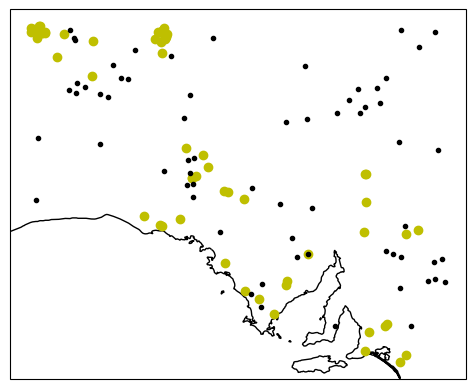

In [20]:
#Quick plot of where commodity deposit data is and generated non-deposit data
ax = plt.axes(projection=ccrs.PlateCarree())
ax.coastlines()
ax.margins(0.05) # 5% padding to the map boundary so we can see the true extent nicely

ax.plot(comm.LONGITUDE, comm.LATITUDE, marker='o', linestyle='', color='y')
ax.plot(lons_rand,lats_rand,marker='.',linestyle='',color='k')

plt.show()

### Define function which performs coregistering/data-mining

In [21]:
def coregLoop(sampleData):
    '''
    Define a function to coregister the grids and perform the spatial data mining.
    
    Requires list of lat and lon, will return the value at that point for all the hardcoded grids
    sampleData=[lat,lon]
    
    Returns array of parameters in the form:
    [lat, lon, param1, param2,...., param92,randomValue]
    
    TODO: Hadrcoded grids currently defined globally. Apply function to pass in grids for finer control.
    '''
    
    lat=sampleData[0]
    lon=sampleData[1]
    #Set the search space over which to sample the geophysical grid
    #Units are in same unit as source grids
    region=100 
    #Set the search sapce to sample the resitivity layers
    region2=100

    #Get the closest Resitivity indexes to the point
    idx,dist=coregPoint([lon,lat],lonlatres,region2)
    
    #Get the distance to the faults from the point
    _,dist=coregPoint([lon,lat],faultsNeo,region2)
    _,dist2=coregPoint([lon,lat],faultsArch,region2)
    _,dist3=coregPoint([lon,lat],faultsGair,region2)

    #Get the Numerical data indexes of the geophys at the point
    xloc1=(np.abs(np.array(x1) - lon).argmin())
    yloc1=(np.abs(np.array(y1) - lat).argmin())
    xloc2=(np.abs(np.array(x2) - lon).argmin())
    yloc2=(np.abs(np.array(y2) - lat).argmin())
    xloc3=(np.abs(np.array(x3) - lon).argmin())
    yloc3=(np.abs(np.array(y3) - lat).argmin())
    xloc4=(np.abs(np.array(x4) - lon).argmin())
    yloc4=(np.abs(np.array(y4) - lat).argmin())
    xloc5=(np.abs(np.array(x5) - lon).argmin())
    yloc5=(np.abs(np.array(y5) - lat).argmin())
    xloc6=(np.abs(np.array(x6) - lon).argmin())
    yloc6=(np.abs(np.array(y6) - lat).argmin())
    xloc7=(np.abs(np.array(x7) - lon).argmin())
    yloc7=(np.abs(np.array(y7) - lat).argmin())
    xloc8=(np.abs(np.array(x8) - lon).argmin())
    yloc8=(np.abs(np.array(y8) - lat).argmin())
    xloc9=(np.abs(np.array(x9) - lon).argmin())
    yloc9=(np.abs(np.array(y9) - lat).argmin())
    xloc10=(np.abs(np.array(x10) - lon).argmin())
    yloc10=(np.abs(np.array(y10) - lat).argmin())
    xloc11=(np.abs(np.array(x11) - lon).argmin())
    yloc11=(np.abs(np.array(y11) - lat).argmin())
    xloc12=(np.abs(np.array(x12) - lon).argmin())
    yloc12=(np.abs(np.array(y12) - lat).argmin())
    xloc13=(np.abs(np.array(x13) - lon).argmin())
    yloc13=(np.abs(np.array(y13) - lat).argmin())
    xloc14=(np.abs(np.array(x14) - lon).argmin())
    yloc14=(np.abs(np.array(y14) - lat).argmin())
    xloc15=(np.abs(np.array(x15) - lon).argmin())
    yloc15=(np.abs(np.array(y15) - lat).argmin())
    xloc16=(np.abs(np.array(x16) - lon).argmin())
    yloc16=(np.abs(np.array(y16) - lat).argmin())
    xloc17=(np.abs(np.array(x17) - lon).argmin())
    yloc17=(np.abs(np.array(y17) - lat).argmin())
    xloc18=(np.abs(np.array(x18) - lon).argmin())
    yloc18=(np.abs(np.array(y18) - lat).argmin())
    xloc19=(np.abs(np.array(x19) - lon).argmin())
    yloc19=(np.abs(np.array(y19) - lat).argmin())
    xloc20=(np.abs(np.array(x20) - lon).argmin())
    yloc20=(np.abs(np.array(y20) - lat).argmin())
    xloc21=(np.abs(np.array(x21) - lon).argmin())
    yloc21=(np.abs(np.array(y21) - lat).argmin())
    xloc22=(np.abs(np.array(x22) - lon).argmin())
    yloc22=(np.abs(np.array(y22) - lat).argmin())
    xloc23=(np.abs(np.array(x23) - lon).argmin())
    yloc23=(np.abs(np.array(y23) - lat).argmin())
    xloc24=(np.abs(np.array(x24) - lon).argmin())
    yloc24=(np.abs(np.array(y24) - lat).argmin())
    xloc25=(np.abs(np.array(x25) - lon).argmin())
    yloc25=(np.abs(np.array(y25) - lat).argmin())
    xloc26=(np.abs(np.array(x26) - lon).argmin())
    yloc26=(np.abs(np.array(y26) - lat).argmin())

    
    #Numerical data values
    z1val=coregRaster([xloc1,yloc1],z1,region)
    z2val=coregRaster([xloc2,yloc2],z2,region)
    z3val=coregRaster([xloc3,yloc3],z3,region)
    z4val=coregRaster([xloc4,yloc4],z4,region)
    z5val=coregRaster([xloc5,yloc5],z5,region)
    z6val=coregRaster([xloc6,yloc6],z6,region)
    z7val=coregRaster([xloc7,yloc7],z7,region)
    z8val=coregRaster([xloc8,yloc8],z8,region)
    z9val=coregRaster([xloc9,yloc9],z9,region)
    z10val=coregRaster([xloc10,yloc10],z10,region)
    z11val=coregRaster([xloc11,yloc11],z11,region)
    z12val=coregRaster([xloc12,yloc12],z12,region)
    z13val=coregRaster([xloc13,yloc13],z13,region)
    z14val=coregRaster([xloc14,yloc14],z14,region)
    z15val=coregRaster([xloc15,yloc15],z15,region)
    z16val=coregRaster([xloc16,yloc16],z16,region)
    z17val=coregRaster([xloc17,yloc17],z17,region)
    z18val=coregRaster([xloc18,yloc18],z18,region)
    z19val=coregRaster([xloc19,yloc19],z19,region)
    z20val=coregRaster([xloc20,yloc20],z20,region)
    z21val=coregRaster([xloc21,yloc21],z21,region)
    z22val=coregRaster([xloc22,yloc22],z22,region)
    z23val=coregRaster([xloc23,yloc23],z23,region)
    z24val=coregRaster([xloc24,yloc24],z24,region)
    z25val=coregRaster([xloc25,yloc25],z25,region)
    z26val=coregRaster([xloc26,yloc26],z26,region)
    
    #Append all the values to an array to return
    #Return dummys for categorical data for now
    vals=np.array([lon,lat])
    vals=np.append(vals,f[:,idx,3])
    vals=np.append(vals,
                   [
                    dist,dist2,dist3,
                    z1val,z2val,z3val,
                    z4val,z5val,z6val,
                    z7val,z8val,z9val,
                        z10val,z11val,z12val,
                    z13val,z14val,z15val,
                    z16val,z17val,z18val,
                    z19val,z20val,z21val,
                    z22val,z23val,z24val,
                    z25val,z26val,
                    -9999.,-9999.
                   ])
    #Append a random choice of 999 or -999 to benchmark ML
    coregMap=np.append(vals,[random.choice([-999, 999])])
    
    #Return the data
    return(coregMap)
    


## Run spatial mining of known deposits and "non-deposits"
Must be re-run on each commodity change. Can be saved and just loaded in if data has already been generated.

In [22]:
#Load in co-registerd training data
# training_data=pd.read_csv("ML-DATA/training_data-"+commname+".csv",header=0)

#Or if that does not exist run next two cells....

In [23]:
#Interrogate the data associated with deposits

#Coregloop takes about 0.07s per call
#shapeExplore takes about 1.7s per call

tic=time.time()
deps1=[]
for row in comm.itertuples():
    lazy_result = coregLoop([row.LATITUDE,row.LONGITUDE])
    #lazy_result = delayed(coregLoop)([row.LATITUDE,row.LONGITUDE])
    deps1.append(lazy_result)
    
vec1=pd.DataFrame(np.squeeze(deps1),columns=lons+numerical_features+categorical_features)
vec1['deposit'] = 1 #Add the "depoist category flag"

toc=time.time()
print("Time deposits:", toc-tic, " seconds")
tic=time.time()

#Interrogate the data associated with randomly smapled points to use as counter-examples
deps0=[]
for lat,lon in zip(lats_rand,lons_rand):
    lazy_result = coregLoop([lat,lon])
    #lazy_result = delayed(coregLoop)([lat,lon])
    deps0.append(lazy_result)
    
vec2=pd.DataFrame(np.squeeze(deps0),columns=lons+numerical_features+categorical_features)
vec2['deposit'] = 0 #Add the "non-deposit category flag"

toc=time.time()
print("Time non-deposits:", toc-tic, " seconds")


#Combine the datasets
training_data = pd.concat([vec1, vec2], ignore_index=True)

tic=time.time()

#Add the categorical shapefile data
shape_objects = [shape(shp) for shp in shapesGeol]
points = [Point(point) for point in zip(training_data.lon, training_data.lat)]
training_data['geol28'] = [shapeExplore(p,shape_objects,recsGeol,1) for p in points]
#training_data.apply(shapeExplore, args=(shape_objects,recsGeol,1), axis=1)
shape_objects = [shape(shp) for shp in shapesArch]
training_data['archean27'] = [shapeExplore(p,shape_objects,recsArch,-1) for p in points]
# training_data.apply(shapeExplore, args=(shape_objects,recsArch,-1), axis=1)

toc=time.time()
print("Time geology:", toc-tic, " seconds")

Time deposits: 46.780417919158936  seconds


/var/folders/77/b51y_4bx5vn95jdnp1lxf8km0000gn/T/ipykernel_12545/2103575592.py:55: RuntimeWarning: Mean of empty slice
  if np.isnan(np.nanmean(pts)):


Time non-deposits: 51.11596179008484  seconds
Time geology: 1.8834271430969238  seconds


In [24]:
#And save the training data out to a file
training_data.to_csv("ML-DATA/training_data-"+commname+".csv")

In [25]:
#Use this to clean rows from ML if particular data does not have exisitng data and would dilute the models too mcuh
# training_data['badsum']=(training_data == -9999.).astype(int).sum(axis=1)
# (training_data == -9999).astype(int).sum(axis=1).value_counts()
# #If many of the points have no data, drop them
# indexNames = training_data[ training_data['badsum'] > 10 ].index
# training_data.drop(indexNames, inplace=True)
# #training_data.drop(columns=['badsum'], inplace=True)
# #indexNames = training_data[ training_data['17dem'] == 0 ].index
# #training_data.drop(indexNames , inplace=True)
# #Save number of deps/non-deps
# lennon=len(training_data.deposit[training_data.deposit==0])
# lendep=len(training_data.deposit[training_data.deposit==1])

# training_data


In [26]:
#Save number of deps/non-deps, to be used for counting later
lennon=len(training_data.deposit[training_data.deposit==0])
lendep=len(training_data.deposit[training_data.deposit==1])
print(lennon,lendep)

#And look at the coregistered training data we have data-mined!
training_data

65 65


,lon,lat,res-25,res-77,res-136,res-201,res-273,res-353,res-442,res-541,...,mag21-tmi,rad22-dose,rad23-k,rad24-th,rad25-u,grav26,archean27,geol28,random,deposit
0,129.200549,-26.106335,1.9954,1.9926,1.9902,1.9880,1.9855,1.9823,1.9778,1.9714,...,119.356041,38.695412,1.212741,7.482955,44.647572,-14.507687,14552,17296,-999.0,1
1,132.775358,-26.107124,2.0450,2.0651,2.0781,2.0881,2.0972,2.1065,2.1164,2.1270,...,-53.695560,57.996395,2.320459,9.896466,44.084831,-54.557907,14552,17068,999.0,1
2,132.770515,-26.125281,2.0450,2.0651,2.0781,2.0881,2.0972,2.1065,2.1164,2.1270,...,-52.042919,57.933865,2.314392,9.886880,44.239040,-55.157433,14552,17068,-999.0,1
3,132.764945,-26.144780,2.0450,2.0651,2.0781,2.0881,2.0972,2.1065,2.1164,2.1270,...,-49.721558,57.838837,2.308796,9.863112,44.357498,-55.753212,14552,17068,-999.0,1
4,129.343013,-26.161717,1.9968,1.9947,1.9926,1.9906,1.9881,1.9848,1.9801,1.9732,...,123.658035,38.647312,1.231678,7.395218,44.299389,-19.222502,14552,17056,-999.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
125,136.172727,-31.170868,2.1216,2.1893,2.2313,2.2581,2.2785,2.2969,2.3151,2.3336,...,84.120407,29.203573,0.696540,5.870744,47.430325,-17.856106,17190,15524,999.0,0
126,137.101092,-31.286865,1.9721,1.9532,1.9377,1.9239,1.9103,1.8957,1.8796,1.8615,...,183.409225,24.405756,0.545605,5.317574,40.734444,-17.208099,17354,17098,-999.0,0
127,138.181016,-28.146123,1.9798,1.9668,1.9546,1.9412,1.9242,1.9025,1.8814,1.8739,...,-103.994904,19.353239,0.490817,3.373940,41.427174,-17.280365,14548,2030,-999.0,0
128,139.709255,-26.101479,1.9892,1.9835,1.9791,1.9754,1.9718,1.9678,1.9631,1.9572,...,-1.247410,21.618067,0.609267,3.558316,41.849396,-18.663504,19208,8106,999.0,0


## Run spatial mining of gawler target data
Only needs to be done once. Each commodity uses this same dataset for targetting. The values of the grid are used to predict whatever commodity is run. Depending on target resolution and whether using parallel versions, can take a good amount of time. 

In [27]:
#Load in target data
# target_data=pd.read_csv("ML-DATA/target_data.csv",header=0)

#OR run the next 5 cells....

In [65]:
################ RUN FROM HERE ONCE (or use the HPC versions for high-res) ##########################
#Make a regularly spaced grid here for use in making a probablilty map later
lats_reg=np.linspace(-36,-26,10)
lons_reg=np.linspace(130,140,10)
#lats_reg=np.arange(min(yval),max(yval)+0.0100,0.0100)
#lons_reg=np.arange(min(xval),max(xval)+0.0100,0.0100)

sampleData=[]
for lat in lats_reg:
    for lon in lons_reg:
            sampleData.append([lat, lon])
            
print(np.size(sampleData))

1800


In [66]:
#Run the data-mining/coregistration
gridgawler=[]
tic=time.time()
i=0
for geophysparams in sampleData:
    #lazy_result = delayed(coregLoop)(geophysparams)
    lazy_result = coregLoop(geophysparams)
    gridgawler.append(lazy_result)
    i+=1
    if i % 50 == 0:
        print(i, geophysparams, time.time()-tic)
print("appended, now running...")

#c=compute(gridgawler)
toc=time.time()

print("Time taken:", toc-tic, " seconds")

/var/folders/77/b51y_4bx5vn95jdnp1lxf8km0000gn/T/ipykernel_12545/2103575592.py:55: RuntimeWarning: Mean of empty slice
  if np.isnan(np.nanmean(pts)):


50 [-35.6551724137931, 136.55172413793105] 41.02306818962097
100 [-34.96551724137931, 133.10344827586206] 84.27962899208069
150 [-34.62068965517241, 140.0] 127.12371516227722
200 [-33.93103448275862, 136.55172413793105] 169.82216382026672
250 [-33.241379310344826, 133.10344827586206] 212.43540287017822
300 [-32.89655172413793, 140.0] 254.30229306221008
350 [-32.206896551724135, 136.55172413793105] 296.04570412635803
400 [-31.517241379310345, 133.10344827586206] 337.9543368816376
450 [-31.17241379310345, 140.0] 379.0617468357086
500 [-30.482758620689655, 136.55172413793105] 419.5474429130554
550 [-29.79310344827586, 133.10344827586206] 460.38634395599365
600 [-29.448275862068964, 140.0] 502.4427561759949
650 [-28.75862068965517, 136.55172413793105] 544.8060829639435
700 [-28.06896551724138, 133.10344827586206] 585.9179630279541
750 [-27.724137931034484, 140.0] 626.652838230133
800 [-27.03448275862069, 136.55172413793105] 666.8010809421539
850 [-26.344827586206897, 133.10344827586206] 70

In [67]:
#Clean up the output file
target_data=pd.DataFrame(np.squeeze(gridgawler),columns=lons+numerical_features+categorical_features)

In [68]:
%%time
#Add the categorical shapefile data
# target_data['geol28']=target_data.apply(shapeExplore, args=(shapesGeol,recsGeol,1), axis=1)
# target_data['archean27']=target_data.apply(shapeExplore, args=(shapesArch,recsArch,-1), axis=1)

#Add the categorical shapefile data
points = [Point(point) for point in zip(target_data.lon, target_data.lat)]
shape_objects = [shape(shp) for shp in shapesGeol]
target_data['geol28'] = [shapeExplore(p,shape_objects,recsGeol,1) for p in points]
shape_objects = [shape(shp) for shp in shapesArch]
target_data['archean27'] = [shapeExplore(p,shape_objects,recsArch,-1) for p in points]

CPU times: user 8.69 s, sys: 168 ms, total: 8.85 s
Wall time: 9.03 s


In [69]:
#Save out the data, and no need to run the co-registration again.
target_data.to_csv("target_data.csv",index=False)

################## RUN TO HERE ONCE #########################

In [70]:
#Look at the target data
#Should be in the same form as the training data WITHOUT the information of whether it is a deposit or non-deposit.
target_data

,lon,lat,res-25,res-77,res-136,res-201,res-273,res-353,res-442,res-541,...,mag20-rtp,mag21-tmi,rad22-dose,rad23-k,rad24-th,rad25-u,grav26,archean27,geol28,random
0,130.000000,-36.0,-0.5216,-0.5210,-0.5206,-0.5203,-0.5199,-0.5195,-0.5190,-0.5185,...,-9999.000000,-9999.000000,-9999.000000,-9999.000000,-9999.000000,-9999.000000,-9999.000000,-9999,1002,-999.0
1,130.344828,-36.0,-0.5218,-0.5213,-0.5209,-0.5206,-0.5202,-0.5198,-0.5194,-0.5189,...,-9999.000000,-9999.000000,-9999.000000,-9999.000000,-9999.000000,-9999.000000,-9999.000000,-9999,1002,999.0
2,130.689655,-36.0,-0.5221,-0.5217,-0.5214,-0.5211,-0.5208,-0.5205,-0.5202,-0.5197,...,-9999.000000,-9999.000000,-9999.000000,-9999.000000,-9999.000000,-9999.000000,-9999.000000,-9999,1002,999.0
3,131.034483,-36.0,-0.5227,-0.5225,-0.5224,-0.5223,-0.5221,-0.5219,-0.5217,-0.5214,...,-9999.000000,-9999.000000,-9999.000000,-9999.000000,-9999.000000,-9999.000000,-9999.000000,-9999,1002,-999.0
4,131.379310,-36.0,-0.5238,-0.5241,-0.5243,-0.5245,-0.5245,-0.5246,-0.5246,-0.5247,...,-9999.000000,-9999.000000,-9999.000000,-9999.000000,-9999.000000,-9999.000000,-9999.000000,-9999,1002,999.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
895,138.620690,-26.0,1.9916,1.9872,1.9839,1.9810,1.9780,1.9747,1.9712,1.9676,...,64.209053,31.185062,-9999.000000,-9999.000000,-9999.000000,-9999.000000,-11.607414,19208,-9999,-999.0
896,138.965517,-26.0,1.9889,1.9829,1.9782,1.9740,1.9695,1.9644,1.9583,1.9516,...,65.945930,25.462706,-9999.000000,-9999.000000,-9999.000000,-9999.000000,-12.741213,19208,-9999,999.0
897,139.310345,-26.0,1.9858,1.9778,1.9714,1.9654,1.9586,1.9503,1.9401,1.9291,...,56.900509,17.390966,-9999.000000,-9999.000000,4.955402,54.122406,-15.171329,19208,-9999,999.0
898,139.655172,-26.0,1.9892,1.9835,1.9791,1.9754,1.9718,1.9678,1.9631,1.9572,...,41.792088,6.395549,31.079834,0.718608,5.112066,50.686985,-18.314697,19208,-9999,-999.0


# Part 3 - Machine learning model

Now we have a fully data-mined, coregistered set of geophysical features. Both for training with known information about our deposits classification labels, and also a target set, we can build and apply the Machine Learning model classifier.

In [71]:
#First, we can check some details about the data. 
#Simple check whether at least MOST of the geophysical parameters have a reasonable value associated with them.
[print(training_data.columns[i],j) for i,j in enumerate(training_data.median())]
#If any of these score -9999.0 it is recommended to remove from that column from analysis
#You can do this, by now "commenting out" the layer in cell 27.

lon 133.6602267229956
lat -29.309229733887605
res-25 2.0355
res-77 2.03625
res-136 2.0433
res-201 2.04465
res-273 2.0494
res-353 2.0542
res-442 2.0545
res-541 2.05365
res-650 2.0602
res-772 2.06215
res-907 2.0612
res-1056 2.0654500000000002
res-1223 2.0614
res-1407 2.067
res-1612 2.06095
res-1839 2.05165
res-2092 2.0735
res-2372 2.0834
res-2683 2.10505
res-3028 2.13945
res-3411 2.1549
res-3837 2.1757
res-4309 2.1849499999999997
res-4833 2.21035
res-5414 2.2399
res-6060 2.2664
res-6776 2.3304
res-7572 2.35345
res-8455 2.3983499999999998
res-9435 2.43835
res-10523 2.4743
res-11730 2.49925
res-13071 2.5333500000000004
res-14559 2.49675
res-16210 2.48155
res-18043 2.5012
res-20078 2.5097500000000004
res-22337 2.5023999999999997
res-24844 2.5055
res-27627 2.5288
res-30716 2.56625
res-34145 2.604
res-37951 2.64095
res-42175 2.6624499999999998
res-46865 2.6873
res-52070 2.7203
res-57847 2.7350000000000003
res-64261 2.7502
res-71379 2.76335
res-79281 2.78255
res-88052 2.7897499999999997
res-97

[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None]

### ML Classification
This is where the ML classifier is defined. We can substitue our favourite ML technique here, and tune model variables as desired. The default choices are recommended for the Gawler region.

In [72]:
training_data['random'] = training_data['random'].astype(str)
training_data[categorical_features] = training_data[categorical_features].astype(str)

In [73]:
#Create the 'feature vector' and a 'target classification vector'
features=training_data[numerical_features+categorical_features]
# features=training_data.iloc[:,80:82]
targets=training_data.deposit

#Create the ML classifier with numerical and categorical data
#Scale, and replace missing values
numeric_transformer = Pipeline(steps=[
    ('imputer',SimpleImputer(missing_values=-9999., strategy='median')),
    ('scaler', StandardScaler())])

#Encode categorical data and fill missing values with default 0
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))])

#Combine numerical and categorical data
preprocessor = ColumnTransformer(transformers=[
        ('num', numeric_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features)])

# Append classifier to preprocessing pipeline.
# Now we have a full prediction pipeline.
rf = Pipeline(steps=[('preprocessor', preprocessor),
                ('classifier', RandomForestClassifier(random_state=1))])

Tranining the Clasifier...
Done RF. Now scoring...
RF 10-fold cross validation Scores: [0.84615385 0.84615385 0.57692308 0.5        0.46153846]
SCORE Mean: 0.65 STD: 0.17 



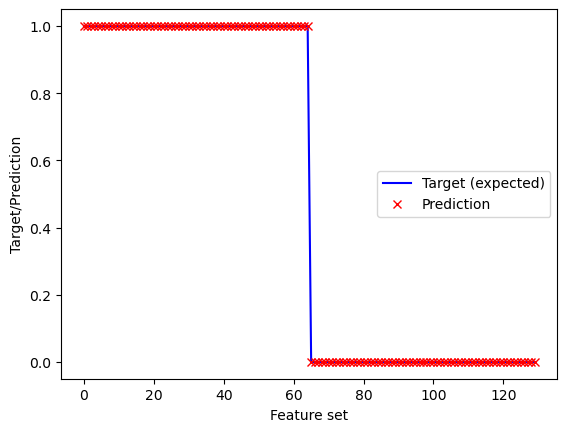

In [74]:
print('Tranining the Clasifier...')
rf.fit(features,targets)

print("Done RF. Now scoring...")
scores = cross_val_score(rf, features,targets, cv=5)

print("RF 10-fold cross validation Scores:", scores)
print("SCORE Mean: %.2f" % np.mean(scores), "STD: %.2f" % np.std(scores), "\n")

plt.plot(targets.values,'b-',label='Target (expected)')
plt.plot(rf.predict(features),'rx',label='Prediction')
plt.xlabel("Feature set")
plt.ylabel("Target/Prediction")
plt.legend(loc=7)

In [75]:
# Gather the importance measures
ft_imp = []
ft_lab = []

for i,lab in enumerate(np.append(numerical_features,rf['preprocessor'].transformers_[1][1]['onehot'].get_feature_names_out(categorical_features))):
    ft_imp.append(rf.steps[-1][1].feature_importances_[i])
    ft_lab.append(lab)

From the Random Forest ML algorithm
these are the the most significant features for predicting the target bins.



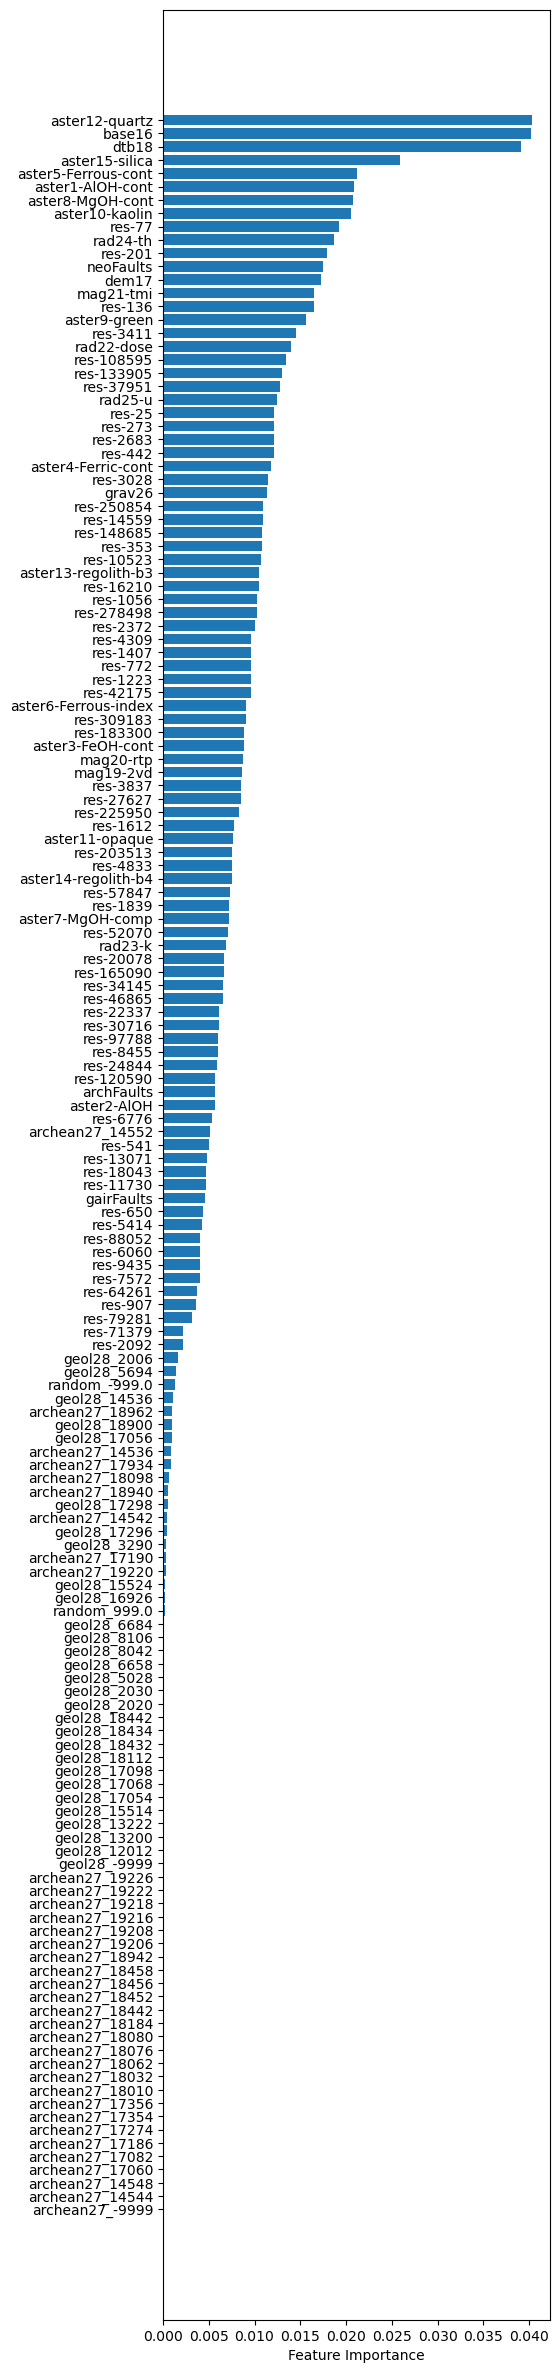

In [76]:
#Make the bar plot
ft_imps, ft_labs = (list(t) for t in zip(*sorted(zip(ft_imp,ft_lab))))
datalength = len(ft_imp)

#Create a new figure
# fig,ax = plt.subplots(figsize=(4,10))
fig, ax = plt.subplots(figsize=(5,30))

#Plot the bar graph
rects = ax.barh(np.arange(0, datalength, step=1),ft_imps)
ax.set_yticks(np.arange(0, datalength, step=1))
ax.set_yticklabels(ft_labs)
ax.set_xlabel('Feature Importance')
print("From the Random Forest ML algorithm\nthese are the the most significant features for predicting the target bins.\n")

plt.show()

RF...
Done RF


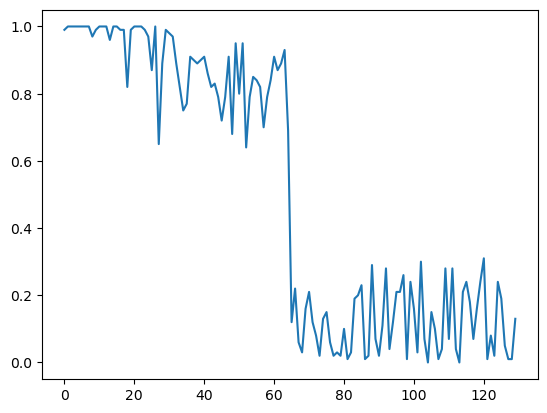

In [77]:
#Chec the probabilities at each of the deposit/non-deposit points
print('RF...')
pRF=np.array(rf.predict_proba(features))
print("Done RF")

plt.plot(pRF[:,1])

## Finally, apply the model to the grid

In [78]:
#Apply the trained ML to our gridded data to determine the probabilities at each of the points
print('RF...')
pRF_map=np.array(rf.predict_proba(target_data[numerical_features+categorical_features]))
print("Done RF")

RF...
Done RF


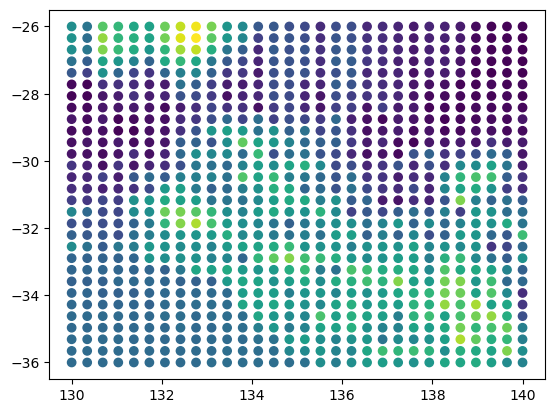

In [79]:
plt.scatter(target_data.lon, target_data.lat, c=pRF_map[:,1])

In [80]:
#Create a meshgrid from our xyz list of points
# gridX,gridY,gridZ=grid(target_data.lon, target_data.lat,pRF_map[:,1])
grid_x, grid_y = np.mgrid[130:140:100j,-36:-26:100j]
gridZ = scipy.interpolate.griddata((target_data.lon, target_data.lat), pRF_map[:,1], (grid_x, grid_y),method='linear')

In [81]:
#Save the csv grid of targets
targetCu = {'Longitude': target_data.lon, 'Latitude': target_data.lat, 'Prediction': pRF_map[:,1]}
targetCu=pd.DataFrame(targetCu)
targetCu.to_csv('Targets-'+commname+'.csv',header=0,index=False)

In [82]:
## Load in some additional SARIG Geochemistry data to compare your results with.
from dbfread import DBF
dbf_file = '../Ni.dbf'
table = DBF(dbf_file, load=True)
nidbf = pd.DataFrame(table.records, columns=table.field_names)
nidbf

,DRILLHOLE_,SAMPLE_NO,DRILLHOL01,DH_DEPTH_F,DH_DEPTH_T,CHEM_CODE,TCA_Value,CHEM_VALUE,CHEM_UNIT,ANALYSIS_M,LATITUDE_G,LONGITUDE_,EASTING_GD,NORTHING_G,ZONE_GDA20
0,FPM 2,6153,1767,74.239998,74.419998,Ni,6.949153,410.0,ppm,AAS,-26.185463,132.549775,255127.67,7101465.60,53
1,WHD 2,6151,1811,47.610001,47.759998,Ni,2.033898,120.0,ppm,AAS,-26.313914,132.731083,273502.82,7087562.71,53
2,DDH KP-2,83542,1812,45.720001,47.849998,Ni,33.898305,2000.0,ppm,AAS,-26.151175,132.781572,278235.75,7105681.46,53
3,MOB 02,48957,2450,30.000000,34.000000,Ni,12.254237,723.0,ppm,AAS,-30.321620,133.491161,354939.25,6644611.22,53
4,MOB 07,48985,2455,48.000000,50.000000,Ni,1.610169,95.0,ppm,AAS,-30.041247,133.131658,319861.29,6675173.42,53
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
38481,JS011,4145102,369984,21.000000,22.000000,Ni,0.893220,52.7,ppm,GA115,-29.592033,133.756030,379529.39,6725773.47,53
38482,JS023,4145116,369986,21.000000,22.000000,Ni,0.872881,51.5,ppm,GA115,-29.589816,133.760187,379929.40,6726023.46,53
38483,JS025,4145123,369988,22.000000,23.000000,Ni,0.269492,15.9,ppm,GA115,-29.588462,133.760204,379929.39,6726173.46,53
38484,JS026,4145125,369989,33.000000,34.000000,Ni,0.505085,29.8,ppm,GA115,-29.587560,133.760215,379929.39,6726273.47,53


/Users/nbutter/miniconda3/envs/geopy/lib/python3.9/site-packages/cartopy/mpl/geoaxes.py:1696: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'vmin', 'vmax' will be ignored
  result = super().scatter(*args, **kwargs)


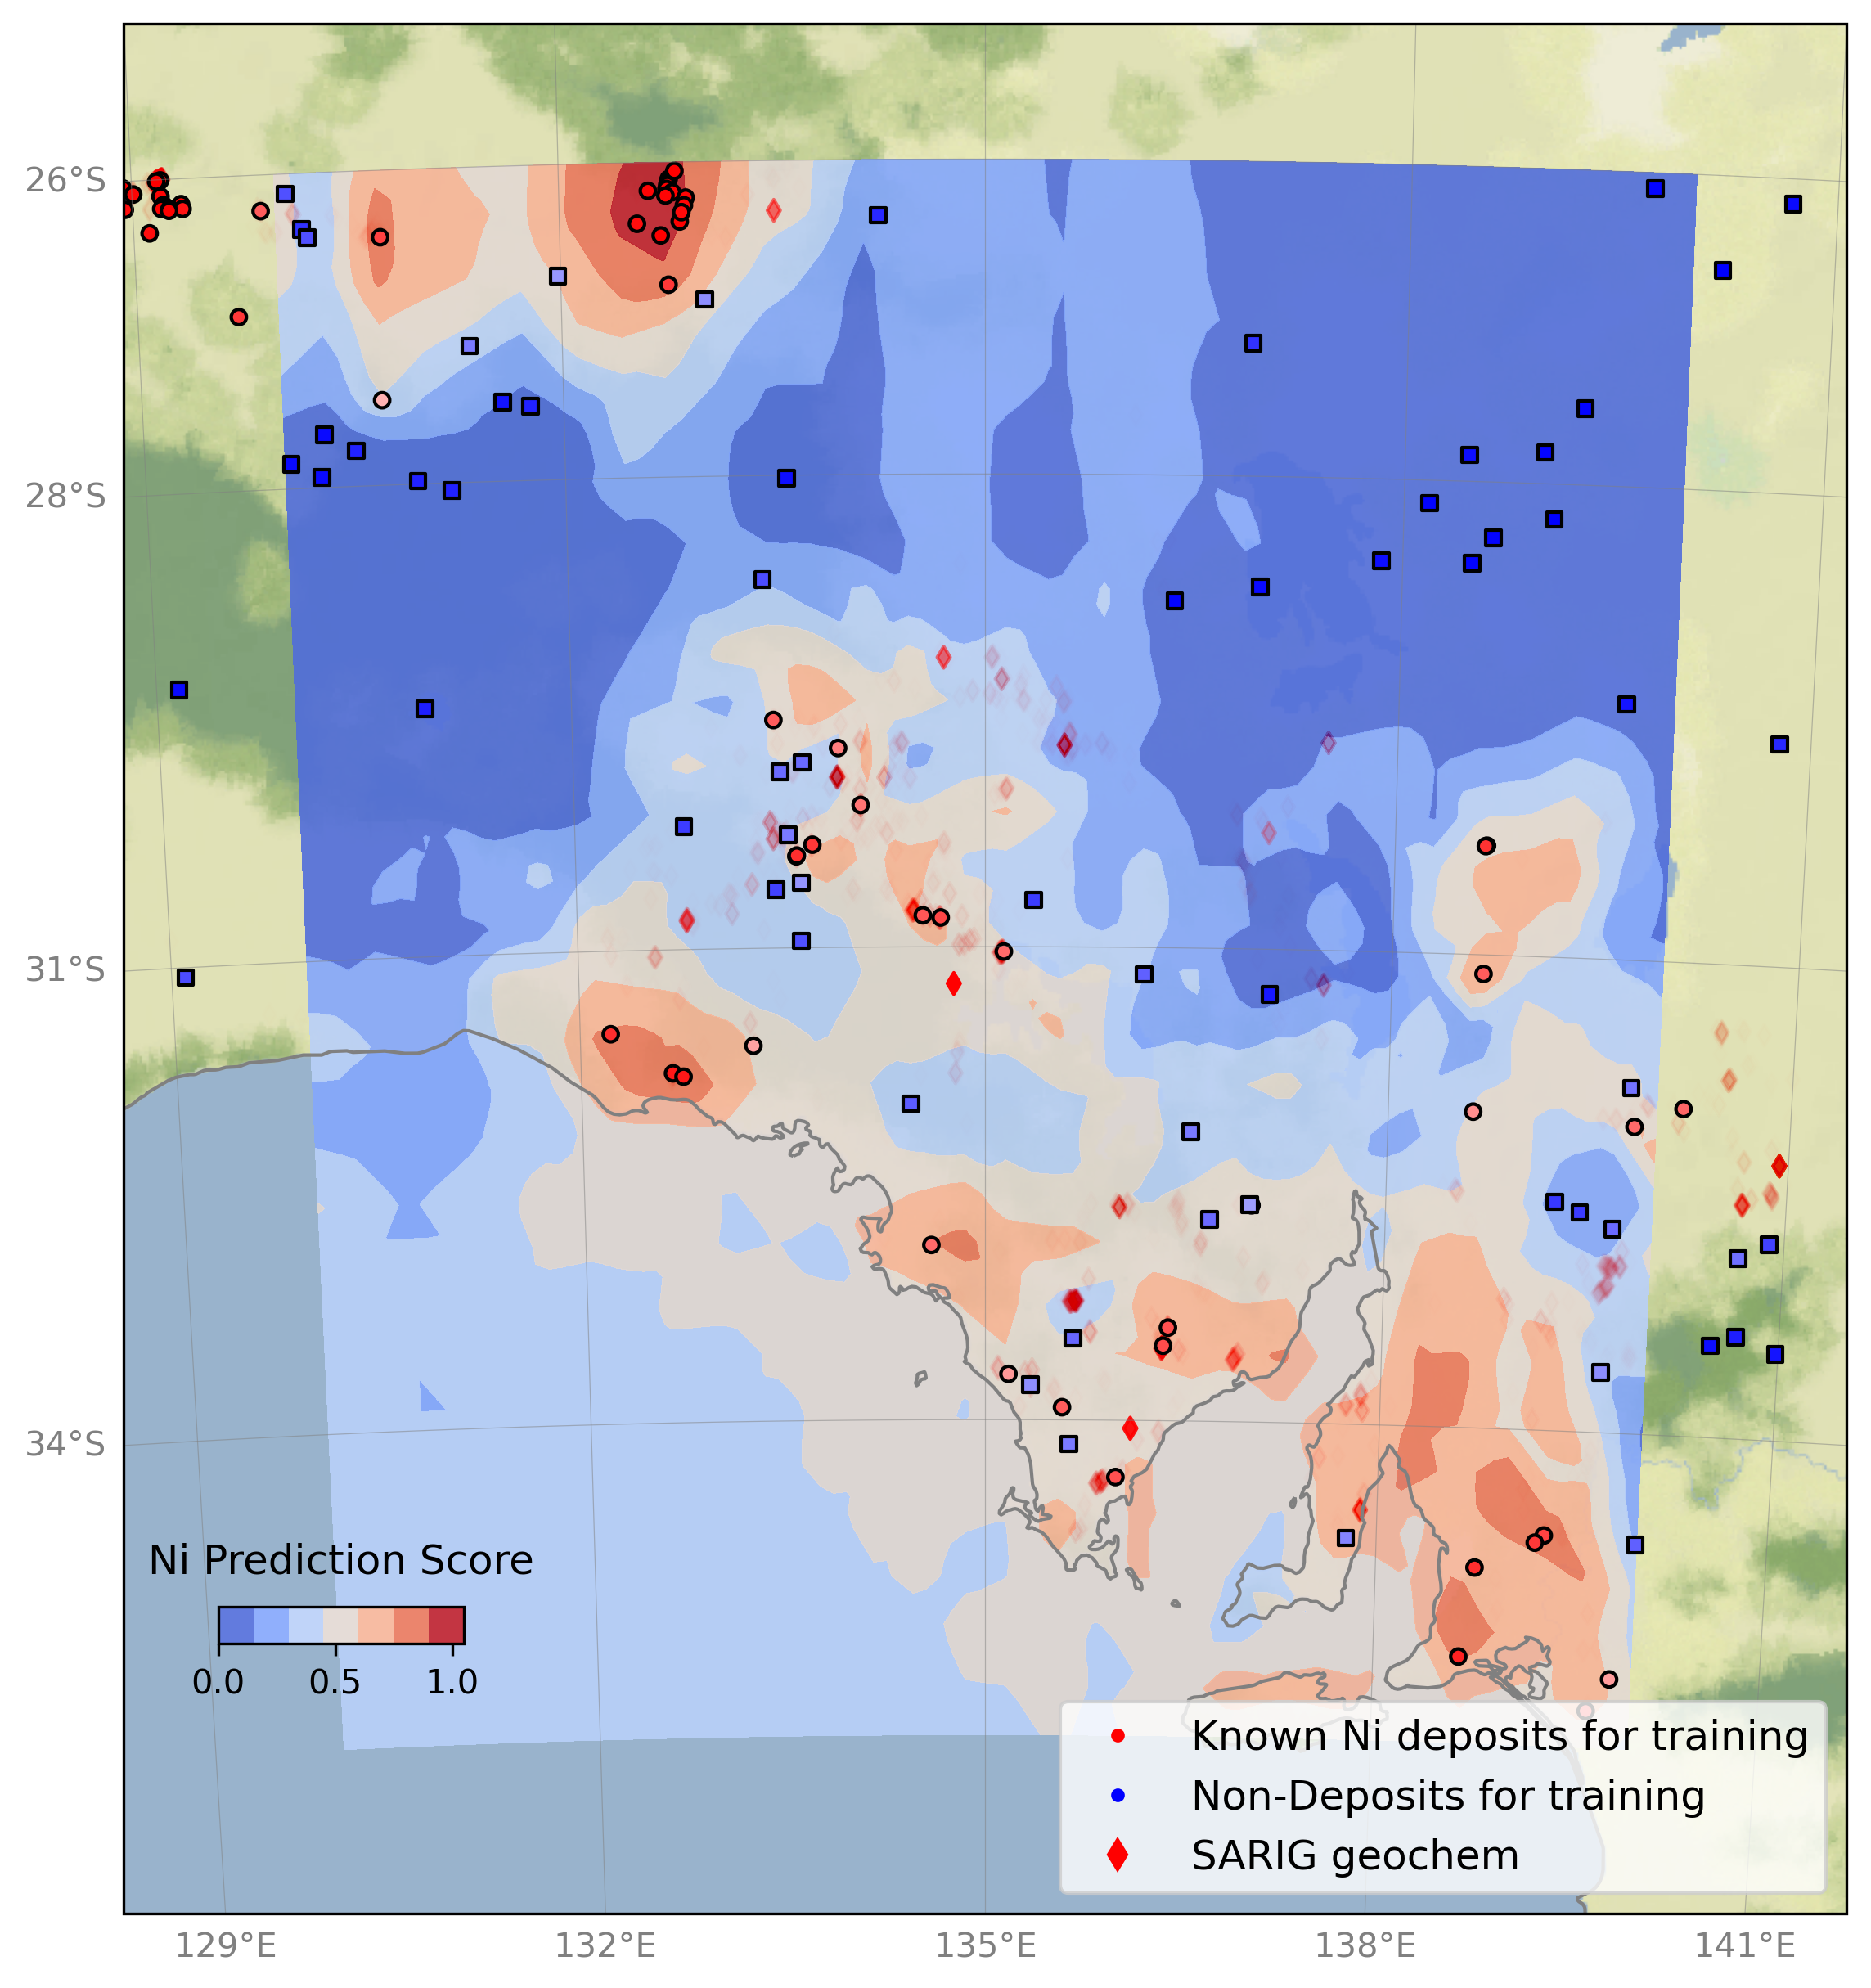

In [83]:
#Plot the final target map
fig = plt.figure(figsize=(10,10),dpi=300)

#Make a map projection to plot on.
ax = plt.axes(projection=ccrs.LambertAzimuthalEqualArea(central_longitude=135.0, central_latitude=-31.0))
       
#Set the extent of interest
# img_extent = [min(df.LONGITUDE)+1.5,  max(df.LONGITUDE)-3.0, min(df.LATITUDE)+5,max(df.LATITUDE)-1]
img_extent = [129,  141, -37 ,-25]
ax.set_extent(img_extent)

#Put down a base map
ax.coastlines(resolution='10m', color='gray',)
tiler = Stamen('terrain-background')
mercator = tiler.crs
ax.add_image(tiler, 6)

#Make the gridlines
gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=0.3, color='gray', alpha=0.5, linestyle='-')
gl.top_labels = False
gl.bottom_labels = True
gl.right_labels = False
gl.left_labels = True
#gl.xlines = False
gl.xlocator = mticker.FixedLocator(list(np.linspace(np.floor(min(df.LONGITUDE))+1,np.ceil(max(df.LONGITUDE))-1,num=5)))
gl.ylocator = mticker.FixedLocator(list(np.linspace(np.floor(min(df.LATITUDE))+1,np.ceil(max(df.LATITUDE))-1,num=5)))
gl.xlocator = mticker.FixedLocator([141,138,135,132,129])
gl.ylocator = mticker.FixedLocator([-38,-34,-31,-28,-26])
#gl.ylocator = mticker.FixedLocator(list(np.linspace(-28,-35,num=3)))
gl.xlabel_style = {'size': 10, 'color': 'gray'}
gl.ylabel_style = {'size': 10, 'color': 'gray'}
#gl.xlabel_style = {'color': 'red', 'weight': 'bold'}
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER

#Plot the main map
im=ax.contourf(grid_x,grid_y,gridZ,
               cmap=plt.cm.coolwarm,
               vmin=0,vmax=1, alpha=0.9,
               transform = ccrs.PlateCarree())

#Add the deposits coloured by their classification score
l4=ax.scatter(training_data.lon[training_data.deposit==0], training_data.lat[training_data.deposit==0],
               edgecolor='k',s=20,marker='s', linewidths=1,label="",
               c=pRF[lendep:,1],cmap=plt.cm.bwr,vmin=0,vmax=1,zorder=3,transform = ccrs.PlateCarree())

l3=ax.scatter(training_data.lon[training_data.deposit==1], training_data.lat[training_data.deposit==1], 
              edgecolor='k',s=20,marker='o', linewidths=1,label="",
              c=pRF[:lendep,1],cmap=plt.cm.bwr,vmin=0,vmax=1,zorder=2,transform = ccrs.PlateCarree())

l5=ax.scatter(nidbf.LONGITUDE_, nidbf.LATITUDE_G, c='r', alpha=nidbf.CHEM_VALUE/max(nidbf.CHEM_VALUE),
              edgecolor=None,s=20,marker='d', linewidths=1,label="",
              cmap=plt.cm.bwr,vmin=0,vmax=100,zorder=1,transform = ccrs.PlateCarree())

ax.plot(0,0,'r.',label='Known '+commname+' deposits for training',zorder=3,transform = ccrs.PlateCarree())
ax.plot(0,0,'b.',label='Non-Deposits for training',zorder=3,transform = ccrs.PlateCarree())
ax.plot(0,0,'rd',label='SARIG geochem',zorder=3,transform = ccrs.PlateCarree())

# Add a map title, legend, colorbar
ax.legend(loc=4,fontsize=12)


cbaxes = fig.add_axes([0.20, 0.22, 0.1, 0.015])
cbar = plt.colorbar(im, cax = cbaxes,orientation="horizontal", ticks=[0.0,0.5,1])
cbar.set_label(commname+' Prediction Score', labelpad=10,fontsize=12)
cbar.ax.xaxis.set_label_position('top')

plt.savefig('Ni_prediction.png')
plt.show()